##### Copyright 2018 The TensorFlow Authors.

# Tree Species Classification using Transfer learning with TensorFlow Hub
the original scripts can be found below:

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

[TensorFlow Hub](https://tfhub.dev/) is a repository of pre-trained TensorFlow models.

This tutorial demonstrates how to:

1. Use models from TensorFlow Hub with `tf.keras`.
1. Use an image classification model from TensorFlow Hub.
1. Do simple transfer learning to fine-tune a model for your own image classes.

In [1]:
#!pip install tensorflow_hub

## Setup

In [24]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
tf.keras.utils.set_random_seed(123)
import datetime

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
def get_labels_from_tfdataset(tfdataset, batched=False):

    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 

    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels

    return labels

## Simple transfer learning

But what if you want to create a custom classifier using your own dataset that has classes that aren't included in the original ImageNet dataset (that the pre-trained model was trained on)?

To do that, you can:

1. Select a pre-trained model from TensorFlow Hub; and
2. Retrain the top (last) layer to recognize the classes from your custom dataset.

## Select image size (usually 224 px but can be larger for some of the models)

In [12]:
img_size=224 

### Dataset

First define the path to the folder where the train and validation data is stored:

In [13]:
#data_root ='data'

First, load this data into the model using the image data off disk with `tf.keras.utils.image_dataset_from_directory`, which will generate a `tf.data.Dataset`:

In [14]:
batch_size = 32
img_height = img_size
img_width = img_size

train_ds = tf.keras.utils.image_dataset_from_directory(
  str('data/train'),#data_root),
  #validation_split=0.2,
  #subset="training",
  #seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str('data/val'),#data_root),
  #validation_split=0.2,
  #subset="validation",
  #seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)



Found 9700 files belonging to 6 classes.
Found 4160 files belonging to 6 classes.


Check what classes are included:

In [15]:
class_names = np.array(train_ds.class_names)
print(class_names)

['betula_pendula' 'fagus_sylvatica' 'fraxinus_excelsior' 'picea_abies'
 'pinus_sylvestris' 'quercus']


Second, because TensorFlow Hub's convention for image models is to expect float inputs in the `[0, 1]` range, use the `tf.keras.layers.Rescaling` preprocessing layer to achieve this.

Note: You could also include the `tf.keras.layers.Rescaling` layer inside the model. Refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide for a discussion of the tradeoffs.

In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

Third, finish the input pipeline by using buffered prefetching with `Dataset.prefetch`, so you can yield the data from disk without I/O blocking issues.

These are some of the most important `tf.data` methods you should use when loading data. Interested readers can learn more about them, as well as how to cache data to disk and other techniques, in the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance#prefetching) guide.

In [17]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

Select a one of the pre-trained model <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" class="external">from TensorFlow Hub</a>. Any <a href="https://tfhub.dev/s?module-type=image-feature-vector&q=tf2" class="external">compatible image feature vector model</a> from TensorFlow Hub will work here, including the examples from the drop-down menu.

In this case we selected a ResNet50 model as it usually performs best compared to mobilnetV2

In [18]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
resnet50 = "https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5"

feature_extractor_model = resnet50 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

Create the feature extractor by wrapping the pre-trained model as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Use the `trainable=False` argument to freeze the variables, so that the training only modifies the new classifier layer:

In [19]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(img_size, img_size, 3),
    trainable=False)

### Attach a classification head

To complete the model, wrap the feature extractor layer in a `tf.keras.Sequential` model and add a fully-connected layer for classification:

In [20]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              23561152  
                                                                 
 dense_1 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 23,573,446
Trainable params: 12,294
Non-trainable params: 23,561,152
_________________________________________________________________


### Train the model

Use `Model.compile` to configure the training process and add a `tf.keras.callbacks.TensorBoard` callback to create and store logs:

In [21]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

Now use the `Model.fit` method to train the model.

To keep this example short, you'll be training for just 10 epochs. To visualize the training progress in TensorBoard later, create and store logs an a [TensorBoard callback](https://www.tensorflow.org/tensorboard/get_started#using_tensorboard_with_keras_modelfit).

In [22]:
NUM_EPOCHS = 30

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)
%tensorboard --logdir logs/fit


Epoch 1/30
304/304 [==============================] - 246s 799ms/step - loss: 0.7691 - acc: 0.7246 - val_loss: 0.6292 - val_acc: 0.7767
Epoch 2/30
304/304 [==============================] - 237s 780ms/step - loss: 0.5414 - acc: 0.8111 - val_loss: 0.5703 - val_acc: 0.8014
Epoch 3/30
304/304 [==============================] - 236s 777ms/step - loss: 0.4765 - acc: 0.8312 - val_loss: 0.5430 - val_acc: 0.8087
Epoch 4/30
304/304 [==============================] - 238s 782ms/step - loss: 0.4355 - acc: 0.8460 - val_loss: 0.5268 - val_acc: 0.8120
Epoch 5/30
304/304 [==============================] - 237s 780ms/step - loss: 0.4058 - acc: 0.8571 - val_loss: 0.5155 - val_acc: 0.8185
Epoch 6/30
304/304 [==============================] - 237s 779ms/step - loss: 0.3824 - acc: 0.8651 - val_loss: 0.5069 - val_acc: 0.8204
Epoch 7/30
304/304 [==============================] - 236s 778ms/step - loss: 0.3630 - acc: 0.8719 - val_loss: 0.5003 - val_acc: 0.8231
Epoch 8/30
304/304 [============================

Reusing TensorBoard on port 6006 (pid 24584), started 2 days, 10:28:20 ago. (Use '!kill 24584' to kill it.)

<!-- <img class="tfo-display-only-on-site" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/images/tensorboard_transfer_learning_with_hub.png?raw=1"/> -->

### Predict on validation dataset

Obtain the ordered list of class names from the model predictions:predicted_id

In [25]:
predicted_batch = model.predict(val_ds)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
#predicted_label_name = class_names[predicted_id]
#reference_label_name=class_names[reference_labels]
#print(predicted_label_name)

### Get labels (id) from the validation dataset

In [26]:
reference_id=get_labels_from_tfdataset(val_ds)

Compute confusion matrix

In [28]:
mat= confusion_matrix(reference_id,predicted_id)

and then plot it

(<Figure size 1152x1152 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

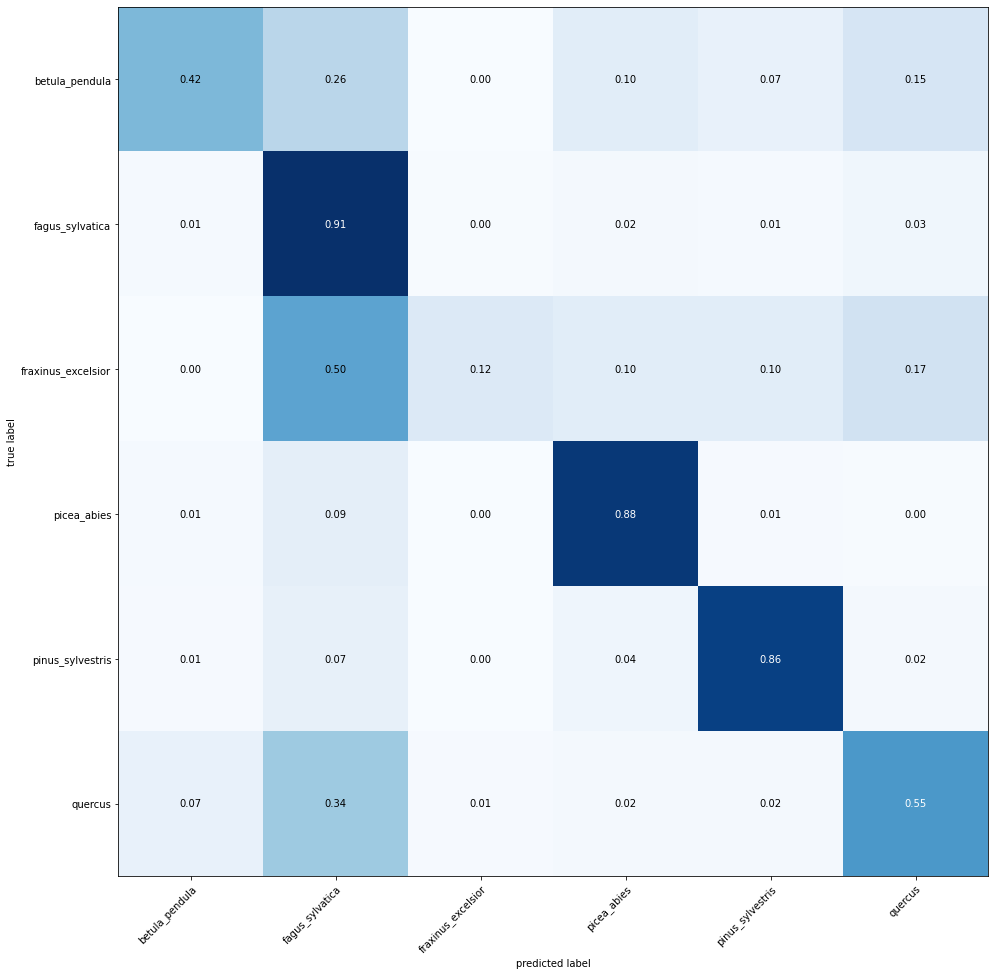

In [29]:
plot_confusion_matrix(conf_mat=mat, figsize=(16,16), class_names=class_names,show_normed=True, show_absolute=False)

## Export and reload your model

Now that you've trained the model, export it as a SavedModel for reusing it later.

##### t = time.time()

export_path = "models/resnet50/{}".format(int(t))
model.save(export_path)

export_path

Confirm that you can reload the SavedModel and that the model is able to output the same results:

In [89]:
reloaded = tf.keras.models.load_model(export_path)

In [90]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [91]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [92]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['fraxinus_excelsior' 'pinus_sylvestris' 'picea_abies']


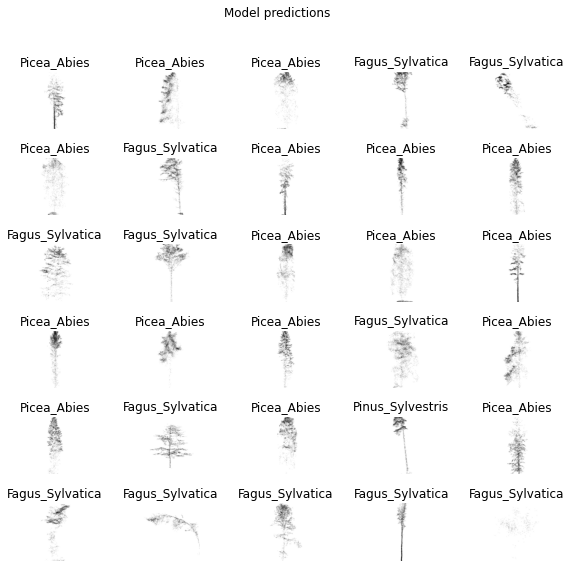

In [44]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Next steps

You can use the SavedModel to load for inference or convert it to a [TensorFlow Lite](https://www.tensorflow.org/lite/models/convert/)  model (for on-device machine learning) or a [TensorFlow.js](https://www.tensorflow.org/js/tutorials#convert_pretrained_models_to_tensorflowjs) model (for machine learning in JavaScript).

Discover [more tutorials](https://www.tensorflow.org/hub/tutorials) to learn how to use pre-trained models from TensorFlow Hub on image, text, audio, and video tasks.